## CAPM Simulation_South Africa

In [2]:
## To evaluate the samll sample properties of the IV method, a battery of simulations are conducted using the parameters
## matched to real data.

In [2]:
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.gmm import IV2SLS
import linearmodels

In [3]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [4]:
df_MR = pd.read_csv('df_MR.csv')

In [5]:
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])

In [6]:
df_MR.set_index('Dates',inplace=True)

In [7]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])

In [8]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)].astype(np.float64)
df_SR.dropna(axis = 0, how = 'all')

,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,0.000000,-0.026116,NaN,-0.070618,NaN,NaN,-0.013234,NaN,-0.016129,NaN,...,0.000000,NaN,0.0,NaN,NaN,-0.109199,NaN,NaN,-0.104700,0.000000
2000-01-06,-0.080043,0.000000,NaN,-0.024693,NaN,NaN,0.034932,NaN,-0.033061,NaN,...,0.081967,NaN,0.0,NaN,NaN,-0.039221,NaN,NaN,0.000000,0.000000
2000-01-07,0.117783,-0.005900,NaN,0.048790,NaN,NaN,0.094951,NaN,-0.042925,NaN,...,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,-0.028988,0.000000
2000-01-10,0.068993,0.015656,NaN,0.000000,NaN,NaN,0.043488,NaN,0.074108,NaN,...,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.084557,0.029559
2000-01-11,-0.068993,0.000000,NaN,-0.048790,NaN,NaN,-0.088186,NaN,0.037740,NaN,...,0.081967,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2019-12-26,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2019-12-27,0.000000,0.000000,0.0,0.000000,0.0,0.0,-0.080043,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.016737,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [9]:
df_Ex_SR = df_SR-df_RF.values

In [10]:
df_Ex_SR = df_Ex_SR.loc[df_MR.index,:]

In [11]:
ols_model = LinearRegression()

In [12]:
## For each stock, we fit market model regressions to esimate constant betas and residual return standard deviation;
## Then we match the simulation paramters (mean&std_dev) to the distribution of these parametes in the real data.

In [13]:
## Constant beta estimations without rolling windows
all_betas = []
all_sigmas = []

betas = []
sigmas = []
labels = []
# j is cross-sectional stock name
for j in tqdm(df_Ex_SR.columns):
    df_index = df_Ex_SR.loc[:,j].dropna().index

    if len(df_index) != 10:
#         lag = int(4*((len(df_Ex_SR.loc[df_index,j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR.loc[df_index,j].values.astype(np.float64), sm.add_constant(df_MR.loc[df_index,:].values.astype(np.float64)))
#         res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
        res = ols.fit()
        b = list(res.params)
        s = np.std(res.resid)
        betas.append(b)
        sigmas.append(s)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_sigmas.append(pd.DataFrame(sigmas))


100%|██████████| 740/740 [00:01<00:00, 456.80it/s]


In [14]:
df_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
df_betas.columns = ['Intercepts','MKT','Stocks']
df_betas = df_betas.set_index('Stocks')
df_betas = df_betas[(np.abs((df_betas-df_betas.mean())/df_betas.std()) <= 3).all(axis=1)]
df_betas

,Intercepts,MKT
Stocks,,
ABC.SJ.Equity,-0.000527,0.012906
ABI.SJ.Equity,-0.000128,0.065382
ABK.SJ.Equity,-0.001182,0.182993
ABR.SJ.Equity,-0.001066,-0.022444
ABU.SJ.Equity,-0.000235,0.010576
...,...,...
ZPT.SJ.Equity,-0.001798,0.079832
ZRNHDG.SJ.Equity,-0.000197,0.012835
ZRNPLY.SJ.Equity,-0.000181,0.000153


In [15]:
## The following is residual return standard deviations
df_sigmas = pd.concat([all_sigmas[0], pd.DataFrame(labels)], axis = 1)
df_sigmas.columns = ['sigmas','Stocks']
df_sigmas = df_sigmas.set_index('Stocks')
df_sigmas = df_sigmas[(np.abs((df_sigmas-df_sigmas.mean())/df_sigmas.std()) <= 3).all(axis=1)]
df_sigmas

,sigmas
Stocks,
ABC.SJ.Equity,0.019822
ABI.SJ.Equity,0.005701
ABK.SJ.Equity,0.044608
ABR.SJ.Equity,0.025737
ABU.SJ.Equity,0.008763
...,...
ZPT.SJ.Equity,0.065835
ZRNHDG.SJ.Equity,0.002140
ZRNPLY.SJ.Equity,0.000040


In [16]:
## We conduct simulations with the cross-sectional size of N=819 stocks. We randomly generat daily returns using the following procedures:
## Step-1: For each stock, we randomly generate a beta and a standard deviations of return residuals from normal distributions.

In [17]:
## ** the mean and standard deviation of simulated beta/residuals the same as the real betas'/residuals' 
m_all_betas = np.mean(df_betas.iloc[:,1])
sd_all_betas = np.std(df_betas.iloc[:,1])
print(m_all_betas, sd_all_betas)

0.16514471061904212 0.21161089569068053


In [18]:
## ** the mean and standard deviation of simulated beta/residuals the same as the real betas'/residuals' 
m_all_sigmas = np.mean(df_sigmas.iloc[:,0].astype('float64'))
sd_all_sigmas = np.std(df_sigmas.iloc[:,0].astype('float64'))
print(m_all_sigmas, sd_all_sigmas)

0.01840973708300509 0.013629287305736423


In [19]:
print(m_all_sigmas*252*100, sd_all_sigmas*np.sqrt(252)*100)

463.92537449172823 21.635822854816876


## beta,i and res_sigma,i are fixed through 100 repetitions

In [20]:
# How many stocks in the simulation sample on cross-sectional scale
N = 500

In [21]:
sim_betas_tmp = []
sim_betas_tmp.append(np.random.normal(loc = m_all_betas,scale = sd_all_betas, size= N ))
np.mean(sim_betas_tmp), np.std(sim_betas_tmp)

(0.17784148172419348, 0.22068176058382338)

In [22]:
sim_betas = pd.DataFrame(sim_betas_tmp)
sim_betas

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-0.171287,0.267465,0.277798,0.486316,-0.034325,0.550062,0.141584,0.276457,0.471385,-0.105723,...,0.345361,-0.278681,-0.177997,0.161925,0.486885,0.412422,0.380742,0.658866,0.091459,-0.080412


In [23]:
sim_sigmas_tmp = []
sim_sigmas_tmp.append(np.random.normal(loc = m_all_sigmas,scale = sd_all_sigmas, size= N ))
np.mean(sim_sigmas_tmp), np.std(sim_sigmas_tmp)

(0.019047557771312982, 0.014215173585096674)

In [24]:
sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()
sim_sig_res

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.028804,0.013595,0.037712,0.006819,0.012132,0.01621,0.03652,0.023753,0.04917,0.020781,...,0.011795,0.001819,0.023833,0.037986,0.001722,0.000016,0.026713,0.044101,0.03112,0.023706


In [25]:
## Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation
## equal to the sample mean and standard deviation from the data

## sim_MKT, sim_SR and res_return are changable through 100 repetitions

In [26]:
mean_MKT = np.mean(df_MR.iloc[:,0])
sd_MKT = np.std(df_MR.iloc[:,0])
print(mean_MKT, sd_MKT)

0.0002807670182166827 0.011549088535812713


In [27]:
print(mean_MKT*252*100, sd_MKT*np.sqrt(252)*100)

7.075328859060404 18.33360968113651


In [28]:
## It's important to make sure that np.mean(sim_MKT_tmp) is precisely equal to mean_MKT, otherwise the gap between 
## ex-ante and ex-post biases will be significant

In [29]:
sim_MKT_tmp = []
sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = sd_MKT, size= len(df_MR)))
print(np.mean(sim_MKT_tmp), np.std(sim_MKT_tmp))

0.0002574450579421769 0.011628093749659077


In [30]:
sim_MKT = pd.DataFrame(sim_MKT_tmp).T
sim_MKT.index = df_MR.index
sim_MKT.columns = ['RM-RF']
sim_MKT

,RM-RF
Dates,
2000-01-05,-0.007106
2000-01-06,0.008459
2000-01-07,0.018471
2000-01-10,0.011427
2000-01-11,-0.013716
...,...
2019-12-25,-0.008012
2019-12-26,-0.017541
2019-12-27,-0.003996


In [31]:
## Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and
## standard deviation equal to the value generate in step-1, i.e. sim_sigmas

In [32]:
res_return = pd.DataFrame(np.zeros((len(sim_MKT), len(sim_sig_res.columns))))
# d = pd.DataFrame(np.zeros((N_rows, N_cols)))
for j in range(len(sim_sig_res.columns)):
    res_return.iloc[:,j] = np.random.normal(loc = 0,scale = sim_sig_res[j], size= len(sim_MKT))
res_return

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-0.007280,-0.001146,-0.016307,0.003098,0.015977,-0.022848,-0.012748,0.023820,0.050431,0.016639,...,-0.004849,-0.000790,0.015400,0.001592,-0.002507,-1.903908e-05,-0.011131,-0.002375,0.035866,-0.003711
1,0.018037,-0.011253,-0.027937,-0.008930,0.000613,-0.004875,-0.002362,0.007398,0.008216,-0.028845,...,0.011789,-0.001250,-0.007676,-0.023992,-0.001343,-2.475392e-05,-0.026510,-0.026141,0.020777,0.017538
2,0.019495,0.001468,-0.024841,0.000243,0.004602,-0.008061,-0.016696,0.018004,0.032527,-0.007346,...,0.016506,0.001538,-0.017328,-0.037126,-0.000942,9.881246e-06,-0.027437,-0.095232,0.025102,0.010735
3,-0.052385,0.015471,0.052847,-0.009142,0.011477,-0.012945,0.050830,0.009008,0.068965,-0.005664,...,-0.011613,-0.002987,-0.020796,-0.050026,-0.001827,6.947121e-06,0.032044,-0.025628,0.001874,0.022899
4,-0.033549,-0.011159,0.038341,-0.002243,0.005165,-0.002166,0.055400,0.025479,0.007573,0.002075,...,-0.012294,-0.000179,0.008593,0.000420,0.000164,-1.782267e-05,-0.020658,0.013080,0.006706,0.002833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5210,0.014100,-0.006039,0.032212,0.015011,0.031216,0.032146,-0.007249,0.017699,0.028533,0.001915,...,-0.002781,-0.000612,0.041984,-0.018592,-0.002769,5.835282e-06,0.018671,0.048207,-0.031206,0.003109
5211,0.007960,-0.021029,0.020133,0.006860,0.012729,-0.002430,0.008535,-0.003480,-0.139601,-0.003484,...,-0.022172,0.000177,-0.022438,0.010143,-0.002408,1.908565e-07,-0.002514,-0.005266,0.003205,-0.045527
5212,0.014487,-0.036484,-0.021732,-0.006148,-0.016318,0.002826,-0.005721,0.025985,-0.040438,-0.022018,...,0.003128,-0.001648,0.024009,0.016090,0.000949,2.703640e-05,-0.020205,-0.055423,-0.033599,-0.018098
5213,-0.003330,0.000739,0.098048,0.006820,-0.000402,0.016025,0.001216,-0.028969,0.048654,-0.021904,...,0.021395,-0.000589,-0.023157,-0.002500,-0.002447,-1.477576e-05,-0.028642,-0.019040,-0.005889,-0.016388


In [33]:
## Step-4: For stock i, we compute its excess return as beta,i*MKT,t + episiloni,,t

In [34]:
sim_SR = (np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return
sim_SR = pd.DataFrame(sim_SR)
sim_SR.index = df_Ex_SR.index
sim_SR

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.006063,-0.003047,-0.018281,-0.000358,0.016221,-0.026757,-0.013754,0.021856,0.047081,0.017390,...,-0.007303,0.001191,0.016665,0.000442,-0.005966,-0.002950,-0.013837,-0.007057,0.035216,-0.003140
2000-01-06,0.016588,-0.008991,-0.025587,-0.004817,0.000323,-0.000222,-0.001165,0.009737,0.012203,-0.029739,...,0.014710,-0.003608,-0.009181,-0.022623,0.002775,0.003464,-0.023290,-0.020568,0.021551,0.016858
2000-01-07,0.016331,0.006408,-0.019710,0.009226,0.003968,0.002099,-0.014080,0.023111,0.041234,-0.009298,...,0.022885,-0.003609,-0.020616,-0.034135,0.008051,0.007628,-0.020405,-0.083063,0.026791,0.009250
2000-01-10,-0.054343,0.018528,0.056021,-0.003585,0.011085,-0.006659,0.052448,0.012167,0.074352,-0.006872,...,-0.007667,-0.006171,-0.022830,-0.048176,0.003737,0.004719,0.036394,-0.018100,0.002919,0.021980
2000-01-11,-0.031200,-0.014828,0.034530,-0.008914,0.005636,-0.009711,0.053458,0.021687,0.001107,0.003525,...,-0.017032,0.003644,0.011034,-0.001801,-0.006514,-0.005675,-0.025881,0.004043,0.005452,0.003936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.015473,-0.008182,0.029986,0.011114,0.031491,0.027739,-0.008384,0.015484,0.024756,0.002762,...,-0.005548,0.001621,0.043410,-0.019890,-0.006669,-0.003298,0.015621,0.042928,-0.031938,0.003753
2019-12-26,0.010964,-0.025721,0.015260,-0.001671,0.013331,-0.012078,0.006052,-0.008329,-0.147870,-0.001629,...,-0.028230,0.005065,-0.019316,0.007303,-0.010948,-0.007234,-0.009192,-0.016823,0.001601,-0.044116
2019-12-27,0.015171,-0.037553,-0.022843,-0.008091,-0.016180,0.000628,-0.006287,0.024881,-0.042321,-0.021596,...,0.001748,-0.000535,0.024721,0.015443,-0.000997,-0.001621,-0.021727,-0.058056,-0.033965,-0.017777


In [35]:
from datetime import datetime
months = []
periods = int(len(sim_SR)/21)+1
mons = pd.date_range(start=sim_SR.index[0], periods = periods, freq='M').astype(str).str[:7]
for i in range(periods):
    m = mons[i]
    months.append(np.repeat(m,21))

In [36]:
## sum daily stock and factor log returns to compute corresponding monthly returns
m_sim_SR = sim_SR
m_sim_SR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_SR = m_sim_SR.groupby('month').sum()
sim_SR = sim_SR.drop(['month'], axis = 1)
m_sim_SR = m_sim_SR.iloc[:-1,:]
m_sim_SR

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
month,,,,,,,,,,,,,,,,,,,,,
2000-01,-0.044797,0.031317,0.075369,-0.019972,-0.038988,-0.059224,0.133543,0.172334,-0.012586,0.017706,...,-0.025665,-0.009470,-0.103283,-0.110192,-0.008681,-0.009956,-0.146799,-0.369820,0.216341,0.212310
2000-02,-0.092362,-0.015574,0.067668,-0.010345,0.062736,-0.110582,0.009892,-0.003203,-0.197416,0.085942,...,-0.020162,0.025299,0.066307,-0.163341,-0.019635,-0.010930,-0.106091,-0.193884,0.108595,0.132731
2000-03,0.057755,0.009060,-0.159675,0.020521,-0.022013,-0.019545,-0.098670,-0.129154,0.046238,0.004899,...,-0.053960,-0.002715,-0.060379,-0.439475,0.009410,0.000560,-0.030772,-0.018476,-0.188998,-0.116585
2000-04,-0.055267,-0.001641,0.112559,0.012094,0.049171,0.035079,0.158816,-0.033080,0.026547,0.008930,...,0.061244,0.013166,0.068913,0.124818,-0.020896,-0.005915,-0.124952,0.002712,0.209375,-0.016699
2000-05,-0.037589,0.014131,-0.056548,-0.046727,-0.036913,-0.032314,-0.095703,0.111809,0.132713,-0.058828,...,-0.053624,0.020214,-0.038353,-0.162530,-0.040993,-0.042495,-0.077764,-0.241540,-0.296944,-0.061760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04,-0.156034,0.040216,-0.233487,0.027376,-0.001335,-0.016723,-0.289978,0.150082,0.102938,-0.097305,...,0.046258,-0.018747,0.238905,0.002246,0.025023,0.025142,-0.237262,0.165659,0.137153,0.275165
2020-05,-0.151098,-0.156930,-0.295479,-0.021624,0.053900,-0.170389,0.034058,-0.073774,-0.091833,-0.007499,...,-0.033363,-0.000231,-0.004220,0.063263,-0.012850,-0.000738,0.036024,0.198993,-0.060589,0.061515
2020-06,-0.447130,0.108251,-0.164651,0.023742,0.020593,-0.138622,0.056472,-0.053384,0.104529,0.059270,...,-0.020605,-0.019826,-0.003343,-0.058820,-0.009149,0.003132,-0.109479,0.131294,-0.021171,-0.115372


In [37]:
m_sim_MKT = sim_MKT
m_sim_MKT['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_MKT = m_sim_MKT.groupby('month').sum()
sim_MKT = sim_MKT.drop(['month'], axis = 1)
m_sim_MKT = m_sim_MKT.iloc[:-1,:]
m_sim_MKT

,RM-RF
month,
2000-01,-0.023817
2000-02,-0.026665
2000-03,0.001061
2000-04,-0.014407
2000-05,-0.103059
...,...
2020-04,0.060896
2020-05,-0.001488
2020-06,0.007448


In [38]:
## Step-5: For the first-stage regression in the simulation, we estimate betas using time series regression (OLS&IV)

### OLS (without rolling window)

In [39]:
# use the factor model in linearmodel module, however, this function would not allow for time-varying beta meaning that
# the result of this FM two-step regression would be the same as cross-sectional regression.
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                500   R-squared:                      0.0192
No. Factors:                          1   J-statistic:                    596.80
No. Observations:                  5215   P-value                         0.0017
Date:                  Tue, Apr 19 2022   Distribution:                chi2(499)
Time:                          23:07:43                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
RM-RF          0.0002     0.0002     1.2580     0.2084     -0.0001      0.0005
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [40]:
print("ex-ante bias(%):" + str(((res_ols.risk_premia-mean_MKT)/mean_MKT*100).values))
print("ex-post bias(%):" + str(((res_ols.risk_premia-sim_MKT.mean())/sim_MKT.mean()*100).values))

ex-ante bias(%):[-23.94426334]
ex-post bias(%):[-17.05437047]


In [41]:
# from linearmodels.asset_pricing import LinearFactorModelGMM
# model_GMM = LinearFactorModelGMM(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
# res_GMM = model_GMM.fit()
# res_GMM

In [42]:
all_betas_test = pd.DataFrame()
all_resids = pd.DataFrame()

# i is time in periods
for j in tqdm(sim_SR.columns):
    
    betas = []
    # j is cross-sectional stock name
#     lag = int(4*((len(sim_SR.loc[:,j]))/100)**(1/9))
    ols = sm.OLS(sim_SR.loc[:,j].values.astype(np.float64), sm.add_constant(sim_MKT.values.astype(np.float64)))
    res = ols.fit()
#     res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
    b = list(res.params)
    r = list(res.resid)
    betas.append(b)
    
    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercept', 1:'MKT'})
    all_betas_test = pd.concat([all_betas_test, df_betas], axis = 0)
    all_resids = pd.concat([all_resids, pd.DataFrame(r)], axis = 1)

100%|██████████| 500/500 [00:01<00:00, 255.22it/s]


In [47]:
all_betas_test = all_betas_test.reset_index(drop=True)
all_betas_test 

,Intercept,MKT
0,-2.068477e-04,-0.153651
1,-2.172838e-04,0.306398
2,-4.663297e-04,0.319179
3,5.651522e-05,0.477890
4,-1.566865e-04,-0.022915
...,...,...
495,-1.027235e-08,0.412422
496,-9.190156e-05,0.342885
497,6.269779e-06,0.608911
498,2.628409e-04,0.099025


In [45]:
all_resids.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-0.006948,-0.000653,-0.015547,0.002982,0.016215,-0.022270,-0.012362,0.023292,0.050671,0.016603,...,-0.004887,-0.000757,0.015007,0.002841,-0.002515,-0.000019,-0.011308,-0.002737,0.035656,-0.004154
1,0.018095,-0.011365,-0.027820,-0.008916,0.000673,-0.004564,-0.002277,0.006943,0.008778,-0.029262,...,0.011616,-0.001235,-0.007168,-0.023221,-0.001351,-0.000025,-0.026098,-0.025725,0.020450,0.016731
2,0.019376,0.000966,-0.025139,0.000342,0.004548,-0.007923,-0.016803,0.017595,0.033296,-0.008007,...,0.016247,0.001542,-0.016241,-0.036661,-0.000949,0.000010,-0.026646,-0.094316,0.024700,0.009694
3,-0.052380,0.015244,0.052840,-0.009103,0.011504,-0.012685,0.050859,0.008566,0.069589,-0.006153,...,-0.011811,-0.002975,-0.020117,-0.049346,-0.001834,0.000007,0.032568,-0.025064,0.001525,0.022023
4,-0.033101,-0.010408,0.039374,-0.002415,0.005478,-0.001474,0.055913,0.024920,0.007677,0.002200,...,-0.012275,-0.000138,0.007817,0.001870,0.000155,-0.000018,-0.021086,0.012388,0.006547,0.002545


In [48]:
corr_x_res = []

for j in tqdm(range(len(all_resids.columns))):
    corr = stats.pearsonr(sim_MKT.values.flatten(), all_resids.iloc[:,j].values)
    corr_x_res.append(corr)

100%|██████████| 500/500 [00:00<00:00, 4275.63it/s]


In [49]:
pd.DataFrame(corr_x_res).head()

,0,1
0,-1.066855e-16,1.0
1,7.988402e-16,1.0
2,1.214306e-17,1.0
3,6.643991e-16,1.0
4,-5.334275e-17,1.0


In [50]:
from statsmodels.graphics.tsaplots import plot_acf

Asset_Number = 213


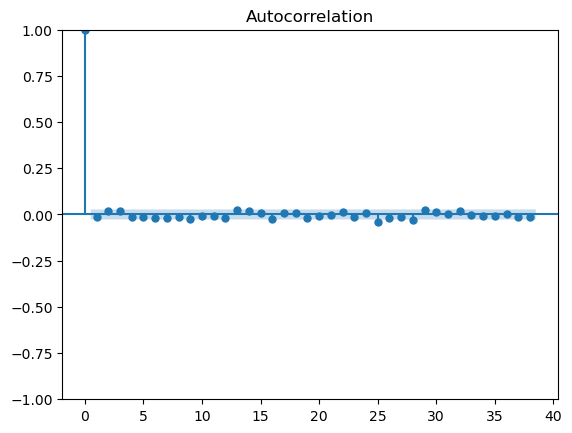

In [51]:
k = np.random.randint(0,len(sim_SR.columns))
plot_acf(all_resids.iloc[:,k])
print('Asset_Number = ' + str(k))
plt.show()

In [52]:
from statsmodels.stats.stattools import durbin_watson

In [55]:
## The null hypothesis of the test is that there is no serial correlation in the residuals. AR(1)
## the value of dw test is very close to 2*(1-rho_hat)
all_dws = []

for j in range(len(all_resids.columns)):
    dw = durbin_watson(all_resids.iloc[:,j])
    all_dws.append(dw)

print(np.mean(all_dws))

2.001809184713201


In [56]:
beta_err = sim_betas - all_betas_test.MKT

In [57]:
durbin_watson(beta_err.T)

array([1.90833787])

In [60]:
lamdas = []

for i in tqdm(range(len(sim_SR))):
    ols = sm.OLS(sim_SR.iloc[i,:], sim_betas.T)
    res = ols.fit()
    l = list(res.params)
    lamdas.append(l)

100%|██████████| 5215/5215 [00:04<00:00, 1299.29it/s]


In [61]:
print(np.mean(lamdas), mean_MKT)

0.00021735018325780736 0.0002807670182166827


In [62]:
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test

In [64]:
## The null hypothesis of the test is that there is no serial correlation in the residuals. AR(n)
all_lbs = []

for j in range(len(all_resids.columns)):
    lb = lb_test(all_resids.iloc[:,j], lags=None, boxpierce=False)
    all_lbs.append(lb)

print(np.mean(all_lbs))

3.036718441833019


In [66]:
lb_test(all_resids.iloc[:,j])

,lb_stat,lb_pvalue
1,0.151587,0.697023
2,0.155391,0.925246
3,2.782385,0.426408
4,3.171183,0.529598
5,3.717959,0.590694
6,4.564225,0.600788
7,4.726827,0.693259
8,5.606514,0.691213
9,8.527308,0.481999
10,8.676644,0.563041


Asset_Number = 34


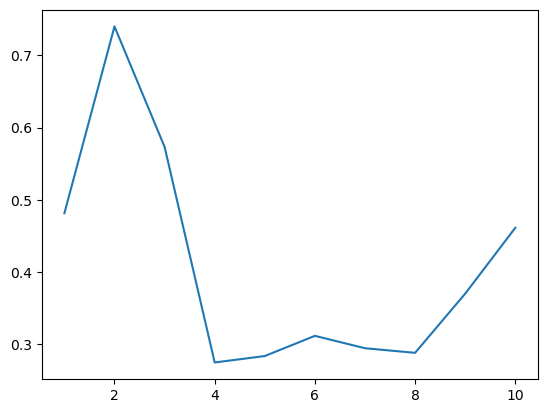

In [99]:
h = np.random.randint(0,len(all_resids.columns))
plt.plot(lb_test(all_resids.iloc[:,h]).iloc[:,1])
print('Asset_Number = ' + str(h))
plt.show()

## OLS (Time-varying Betas)

In [207]:
# how many years in the rolling window periods
n = 2

In [208]:
holding = 21 # 1 month
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

223 504


In [209]:
all_betas = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    # j is cross-sectional stock name
    for j in sim_SR.columns:      
#         lag = int(4*((len(sim_SR.loc[:,j]))/100)**(1/9))
        OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sm.add_constant(sim_MKT_tmp.values.astype(np.float64)))
        res = OLS.fit()
#         res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
        b = list(res.params)
        betas.append(b)

    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercepts',1:'MKT'})
    all_betas.append(df_betas)

100%|██████████| 223/223 [00:31<00:00,  7.09it/s]


In [210]:
all_betas[0]

,Intercepts,MKT
0,-5.965053e-04,-0.117708
1,3.835728e-04,0.335056
2,1.141567e-03,0.340580
3,3.520063e-04,0.479672
4,-4.480176e-04,-0.109373
...,...,...
495,3.261412e-07,0.412487
496,-1.351195e-03,0.514547
497,1.770905e-03,0.543424
498,4.789545e-04,0.223162


In [211]:
corr_betas_true = []

for i in range(len(all_betas)):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_betas_true.append(corr)

print(np.mean(corr_betas_true), stats.ttest_1samp(corr_betas_true, 0.0)[0])

0.9196405747738265 1680.9150264809919


In [212]:
holding = 1 # 1 month
rollingW = holding *n*12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

223 24


In [213]:
# sum daily market return to compute corresponding monthly returns
m_MR = df_MR
m_MR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_MR = m_MR.groupby('month').sum()
df_MR = df_MR.drop(['month'], axis = 1)
m_MR = m_MR.iloc[:-1,:]
m_MR

,MR_RF
month,
2000-01,0.0154
2000-02,-0.0955
2000-03,-0.0024
2000-04,-0.0693
2000-05,-0.0119
...,...
2020-04,-0.0695
2020-05,0.0382
2020-06,-0.0010


In [214]:
all_lambdas_OLS = []
all_resids_OLS = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):   
    i = int(index_times.index(k)/holding)
    OLS = sm.OLS(m_sim_SR_tmp_T.loc[:,k], sm.add_constant(all_betas[i].loc[:,"MKT"].astype(np.float64)))
    res = OLS.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)
        
all_lambdas_OLS.append(pd.DataFrame(lambdas))
all_resids_OLS.append(pd.DataFrame(resids))

100%|██████████| 223/223 [00:00<00:00, 710.51it/s]


In [215]:
all_lambdas_OLS[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.006558,-0.033426
1,-0.009305,-0.011823
2,0.011689,0.112545
3,0.006567,0.027203
4,0.000016,-0.016701
...,...,...
218,-0.001574,-0.100245
219,-0.005268,0.060490
220,-0.013117,0.000414
221,-0.001996,-0.028201


In [216]:
all_resids_OLS = pd.DataFrame(all_resids_OLS[0].T)
all_resids_OLS

,0,1,2,3,4,5,6,7,8,9,...,213,214,215,216,217,218,219,220,221,222
0,0.023652,0.099041,-0.233616,-0.087728,-0.069503,0.071430,0.038151,0.126377,0.075772,-0.124359,...,-0.085563,0.165571,-0.313949,-0.268233,-0.174689,-0.022176,-0.147552,-0.137941,-0.447117,0.073915
1,-0.059601,0.095063,0.059214,-0.058394,0.116386,0.056562,0.047696,0.109011,0.177523,-0.025682,...,-0.076977,0.069727,-0.044320,0.056320,-0.140740,-0.140394,0.023706,-0.143951,0.119276,0.016224
2,-0.026858,0.247911,-0.325623,0.081614,0.087256,-0.035275,0.027381,-0.040386,0.128687,0.169044,...,0.092118,0.050842,-0.056162,-0.079337,0.092902,-0.180249,-0.254360,-0.282539,-0.151177,-0.439983
3,0.016070,-0.011312,-0.019035,-0.020163,-0.044082,0.085084,0.050994,0.021405,-0.038299,0.011235,...,-0.033855,0.015279,0.011262,-0.022684,0.022283,-0.013265,0.003327,-0.008708,0.039512,-0.005223
4,-0.035066,-0.002928,-0.035478,-0.023821,-0.094105,0.001913,-0.078648,0.006735,0.105095,0.000759,...,0.007213,-0.000177,0.014956,0.005302,-0.070732,-0.020780,0.008616,0.067047,0.020221,0.004594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.004645,-0.005767,0.004714,0.002690,-0.012039,0.015430,0.012914,-0.001174,-0.001546,-0.006639,...,0.002496,0.002136,0.001845,0.003769,0.008677,-0.006276,0.005463,0.012209,0.016758,-0.009565
496,-0.083121,-0.036787,0.134369,-0.044607,0.148847,0.072972,0.017903,0.089202,0.143563,-0.050810,...,0.101489,0.184482,0.267233,-0.049191,0.067828,0.103958,-0.248596,0.049035,-0.100266,0.016240
497,0.135828,0.162618,-0.101574,0.026485,-0.242508,-0.015274,-0.041552,-0.041431,0.129512,-0.039203,...,-0.169649,-0.075833,0.026879,0.031601,-0.142149,-0.009130,0.150277,0.211958,0.144163,-0.346456
498,0.180531,-0.008234,-0.320011,-0.058527,0.034140,0.202294,-0.118006,0.089150,-0.007536,0.055374,...,-0.061568,0.016510,-0.068548,0.257722,-0.214305,-0.044803,0.137432,-0.047495,-0.017352,-0.019671


In [217]:
stats.ttest_1samp(all_lambdas_OLS[0], 0.0)

Ttest_1sampResult(statistic=array([0.37866112, 0.95533529]), pvalue=array([0.70530141, 0.34044728]))

In [258]:
## ***Risk Premium estimate for one simulation
all_lambdas_OLS[0].iloc[:,1].mean() # simulation market premium
## ***Corresponding true simulation parameters, 0.0002807670182166827 is our true daily market risk premium, i.e. 0.07075328859060404 per annum
np.mean(m_MR) #true market premium
print(m_MR.values.mean(), all_lambdas_OLS[0].iloc[:,1].mean())

0.00593024193548387 0.003269329185974521


In [219]:
# Test whether the betas in FM-2 is endougenous

In [220]:
corr_betas_res = []

for i in range(np.shape(all_resids_OLS)[1]):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),all_resids_OLS.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_betas_res.append(corr)

print(np.mean(corr_betas_res), "x is Endogenous" if np.mean(corr_betas_res).round(10)!=0 else "x is Exogenous")

5.2401484372415996e-18 x is Exogenous


In [221]:
m_MR_tmp = m_MR.iloc[rollingW+1:len(m_MR),:]
m_sim_MKT_tmp = m_sim_MKT.iloc[rollingW+1:len(m_MR),:]

In [222]:
print(np.mean(m_MR.values),np.mean(all_lambdas_OLS[0].iloc[:,1].values))

0.00593024193548387 0.0032693291859745136


In [223]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_MR.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))

ex-ante bias(%): -44.870222470817886
ex-post bias(%): -40.2314434576741


In [224]:
## The Ex-ante RMSE
diff = all_lambdas_OLS[0].iloc[:,1]-np.array(m_MR_tmp).flatten()
np.sqrt((diff**2).mean())

0.07073413195015026

In [225]:
## The Ex-post RMSE
diff = all_lambdas_OLS[0].iloc[:,1]-np.array(m_sim_MKT_tmp).flatten()
np.sqrt((diff**2).mean())

0.07931952316503828

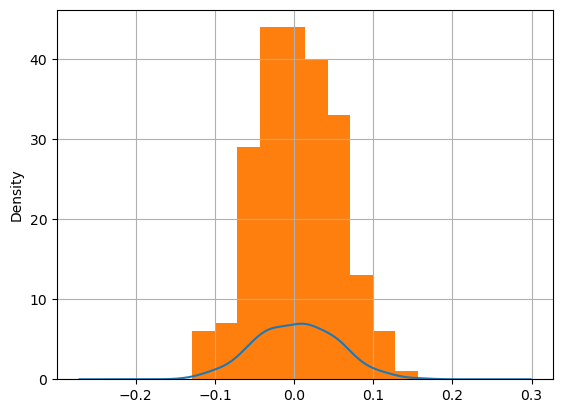

In [226]:
all_lambdas_OLS[0].iloc[:,1].plot(kind='density')
all_lambdas_OLS[0].iloc[:,1].hist()
plt.show()

## IV(Time-varying Betas)

In [227]:
holding = 21
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(rollingW, periods)

504 223


In [228]:
all_betas_ev = []
all_betas_iv = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is cross-sectional stock label
        for j in sim_SR.columns:
            df_index = rw_odd.index
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)
        
        rw_even = pd.DataFrame()         
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)      
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_odd.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)        
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)
        
        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index         
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)

100%|██████████| 223/223 [02:07<00:00,  1.74it/s]


In [229]:
all_betas_ev[0]

,0
0,-0.165771
1,0.396302
2,0.242605
3,0.496309
4,-0.087855
...,...
495,0.412410
496,0.512500
497,0.291657
498,0.165711


In [230]:
all_betas_iv[0]

,0
0,-0.063648
1,0.272222
2,0.452396
3,0.456187
4,-0.131556
...,...
495,0.412563
496,0.504851
497,0.791703
498,0.259254


## Correlation between ev_errors and iv_errors

In [341]:
h = np.random.randint(0,periods)
beta_err_ev = all_betas_ev[h].values - sim_betas.T.values
beta_err_iv = all_betas_iv[h].values - sim_betas.T.values
stats.pearsonr(beta_err_ev.flatten(), beta_err_iv.flatten())

(0.13499759583083573, 0.0024868170337375953)

In [ ]:
for i in range(periods):
    

In [231]:
## Calculating the estimated lambdas

In [232]:
holding = 1 # 1 month
rollingW = holding * n *12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

223 24


In [233]:
# A rule of thumb is the first stage (i.e., the regression of x on the instrument and any covariates)
# should have an F statistic of at least 10.

fvalues = []

for i in tqdm(range(len(all_betas_ev))):
    ols = sm.OLS(all_betas_ev[i].values.astype(np.float64), sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
    res = ols.fit()
    f = res.fvalue
    fvalues.append(f)


100%|██████████| 223/223 [00:00<00:00, 3377.35it/s]


In [234]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     563.6
Date:                Tue, 19 Apr 2022   Prob (F-statistic):           6.81e-84
Time:                        23:27:57   Log-Likelihood:                 148.86
No. Observations:                 500   AIC:                            -293.7
Df Residuals:                     498   BIC:                            -285.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0263      0.010      2.653      0.008       0.007       0.046
x1             0.7539      0.032     23.741      0.000       0.692       0.816
==============================================================================
Omnibus:                       65.381   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              576.136
Skew:                          -0.050   Prob(JB):                    7.83e-126
Kurtosis:                       8.258   Cond. No.                         4.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [235]:
pd.DataFrame(fvalues).describe()

,0
count,223.000000
mean,605.438923
std,93.856631
min,405.534812
25%,535.172272
50%,599.452889
75%,660.368209
max,890.355675


In [236]:
from linearmodels.iv.model import IV2SLS
# from linearmodels.iv.model import IVGMM
all_lambdas_IV = []
all_resids_IV = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    iv = IV2SLS(dependent = m_sim_SR_tmp_T.loc[:,k].values,\
                exog = np.ones(len(m_sim_SR.T), dtype=np.uint8),\
                endog = all_betas_ev[i].values.astype(np.float64),\
                instruments = all_betas_iv[i].values.astype(np.float64))
    res = iv.fit()
    l = list(res.params)
    r = list(res.resids)
    lambdas.append(l)
    resids.append(r)

all_lambdas_IV.append(pd.DataFrame(lambdas))
all_resids_IV.append(pd.DataFrame(resids))

100%|██████████| 223/223 [00:00<00:00, 271.18it/s]


In [237]:
res.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:              dependent   R-squared:                     -0.0006
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0026
No. Observations:                 500   F-statistic:                    0.8554
Date:                Tue, Apr 19 2022   P-value (F-stat)                0.3550
Time:                        23:27:57   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog          -0.0085     0.0066    -1.2934     0.1959     -0.0215      0.0044
endog          0.0283     0.0306     0.9249     0.3550     -0.0317      0.0883
==============================================================================

Endogenous: endog
Instruments: instruments
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [238]:
res.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.8511
P-value: 0.3567
Distributed: F(1,497)
WaldTestStatistic, id: 0x7fe310a5fc70

In [239]:
# from statsmodels.sandbox.regression.gmm import IV2SLS

# all_lambdas_IV = []
# all_resids_IV = []
# # i is time

# m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

# lambdas = []
# resids = []
# index_times = list(m_sim_SR_tmp_T.columns)

# for k in tqdm(m_sim_SR_tmp_T.columns):
    
#     i = int(index_times.index(k) / holding)
    
#     iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = sm.add_constant(all_betas_ev[i].values.astype(np.float64)),\
#                 instrument = sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
# #     iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = all_betas_ev[i].values.astype(np.float64),instrument = all_betas_iv[i].values.astype(np.float))
#     res = iv.fit()
#     l = list(res.params)
#     r = list(res.resid)
#     lambdas.append(l)
#     resids.append(r)

# all_lambdas_IV.append(pd.DataFrame(lambdas))
# all_resids_IV.append(pd.DataFrame(resids))


In [240]:
# Use the IV estimator equation to calculate lambdas

In [241]:
lam = []
for i in range(periods):
    a = np.dot(np.array(all_betas_iv[i]).T,np.array(all_betas_ev[i]))
    b = np.dot(np.array(all_betas_iv[i]).T, np.array(m_sim_SR_tmp_T.iloc[:,i]))
    l = np.linalg.inv(a)*b
    lam.append(l)

In [242]:
print(np.mean(lam),stats.ttest_1samp(lam, 0.0)[0])

0.004349441454757324 [[1.08062872]]


In [243]:
all_resids_IV = pd.DataFrame(all_resids_IV[0].T)
all_resids_IV

,0,1,2,3,4,5,6,7,8,9,...,213,214,215,216,217,218,219,220,221,222
0,0.017621,0.090031,-0.225109,-0.091992,-0.080287,0.057107,0.022044,0.134312,0.067525,-0.120756,...,-0.098674,0.160045,-0.306908,-0.265248,-0.179017,-0.033583,-0.145710,-0.139961,-0.449649,0.073831
1,-0.054935,0.100548,0.051606,-0.056584,0.122363,0.061667,0.053784,0.108526,0.177790,-0.025530,...,-0.071011,0.068771,-0.045704,0.054079,-0.141308,-0.144192,0.025211,-0.142702,0.121202,0.016206
2,-0.029440,0.248402,-0.315849,0.085246,0.086732,-0.042771,0.026685,-0.031579,0.123589,0.170000,...,0.102522,0.054481,-0.064637,-0.081940,0.098651,-0.166369,-0.259164,-0.279949,-0.144716,-0.440970
3,0.020497,-0.004129,-0.023313,-0.015888,-0.037321,0.089266,0.060220,0.022829,-0.036800,0.009708,...,-0.022088,0.018659,0.002452,-0.025836,0.027390,-0.002352,-0.001675,-0.005682,0.050149,-0.008607
4,-0.037794,-0.007277,-0.036892,-0.027868,-0.098309,0.002167,-0.083770,0.003221,0.105588,0.000842,...,0.004714,0.005623,0.009635,0.007864,-0.069146,-0.011671,0.004852,0.065541,0.017354,0.004295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.007463,-0.000951,0.003293,0.006092,-0.007281,0.016937,0.018839,0.001377,-0.001843,-0.007138,...,0.008729,0.001662,-0.000194,0.001412,0.011426,-0.001920,0.003934,0.014247,0.023042,-0.011293
496,-0.079115,-0.032661,0.136407,-0.040487,0.155068,0.073531,0.023794,0.092842,0.140649,-0.049852,...,0.095225,0.175642,0.278924,-0.049965,0.063161,0.089218,-0.243647,0.049199,-0.101919,0.017452
497,0.128720,0.160237,-0.079110,0.032591,-0.245425,-0.035843,-0.044497,-0.029158,0.118030,-0.038529,...,-0.152804,-0.064810,-0.003096,0.029181,-0.129753,0.024328,0.138188,0.214742,0.157910,-0.351642
498,0.178340,-0.009567,-0.319200,-0.058989,0.029814,0.192356,-0.126817,0.092720,-0.010795,0.056471,...,-0.076815,-0.001197,-0.035510,0.258098,-0.230951,-0.092531,0.160354,-0.051025,-0.034706,-0.010586


In [244]:
# # Plot the distrubtion of the residuals
# label = all_resids_IV.index
# index = all_resids_IV.columns

# # Get the shape of df_residuals
# shape = all_resids_IV.shape

# plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)

# for j in tqdm(range(shape[1])):
#     plt.plot(all_resids_IV.iloc[:,j],)  

# plt.title('The distrubtion of residuals')
# # plt.xticks(np.arange(min(label), max(label)+1, 12), fontsize = 6)
# plt.xticks([], [])
# plt.yticks(fontsize = 6)
# # plt.xlabel('Stock Labels', fontsize = 10)
# plt.ylabel('Residuals', fontsize = 10)
# plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5, axis='y')
# plt.tight_layout()
# plt.show()

In [245]:
## test whether beta_iv (instrumental variables) is exogenous
corr_iv_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_iv[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_iv_res.append(corr)

print(np.mean(corr_iv_res), "IV is Endogenous" if np.mean(corr_iv_res).round(10)!=0 else "IV is Exogenous") 

4.548787231288959e-18 IV is Exogenous


In [246]:
## test whether beta_ev (explanatory variables) is exogenous
corr_ev_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_ev_res.append(corr) 
    
print(np.mean(corr_ev_res), "EV is Endogenous" if np.mean(corr_ev_res).round(10)!=0 else "EV is Exogenous") 


-0.00519183281237757 EV is Endogenous


In [247]:
## weak instrument variable test
## the following calculate the average cross-sectional correlations between odd- and even-month betas 

In [248]:
corr_ev_iv = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_betas_iv[i].values.astype(np.float64).flatten())[0]
    corr_ev_iv.append(corr)
    
print(np.mean(corr_ev_iv), "IV is Strong" if np.mean(corr_ev_iv)>0.5 and stats.ttest_1samp(corr_ev_iv, 0.0)[0] > 2 else "IV is Weak")

0.7381219981681566 IV is Strong


In [249]:
## and also calculate the average cross-sectional correlations between estimated and true betas 

In [250]:
corr_ev_true = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_ev_true.append(corr)

print(np.mean(corr_ev_true), stats.ttest_1samp(corr_ev_true, 0.0)[0])

0.8526603198542817 733.5931455030928


In [251]:
all_lambdas_IV[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.008905,-0.045956
1,-0.005536,-0.032642
2,0.010055,0.119988
3,0.009081,0.012864
4,0.003771,-0.037343
...,...,...
218,0.000595,-0.116067
219,-0.005653,0.065134
220,-0.011706,-0.007949
221,0.001625,-0.052225


In [252]:
stats.ttest_1samp(all_lambdas_IV[0], 0.0)

Ttest_1sampResult(statistic=array([-0.17860451,  1.10815155]), pvalue=array([0.85841114, 0.2689955 ]))

In [253]:
all_lambdas_IV[0].describe()

,0,1
count,223.000000,223.000000
mean,-0.000084,0.004583
std,0.007012,0.061766
min,-0.020536,-0.158993
25%,-0.004606,-0.041830
50%,0.000504,0.006785
75%,0.004587,0.052263
max,0.018384,0.184549


In [254]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_MR.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))   

ex-ante bias(%): -22.71020091298292
ex-post bias(%): -16.206813560382546


In [255]:
## The Ex-ante RMSE
diff = all_lambdas_IV[0].iloc[:,1]-np.array(m_MR_tmp).flatten()
np.sqrt((diff**2).mean())

0.07722468488901091

In [256]:
## The Ex-post RMSE
diff = all_lambdas_IV[0].iloc[:,1]-np.array(m_sim_MKT_tmp).flatten()
np.sqrt((diff**2).mean())

0.0866926483377702

## OLS with beta_ev

In [111]:
from linearmodels.iv.model import IV2SLS

all_lambdas_ols = []
all_resids_ols = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    ols = IV2SLS(dependent = m_sim_SR_tmp_T.loc[:,k].values,\
                exog = pd.concat([pd.DataFrame(np.ones(len(m_sim_SR.T), dtype=np.uint8)).T, all_betas_ev[i].T], axis =0,ignore_index=True).T,\
                endog = None,\
                instruments = None)
    res = ols.fit()
    l = list(res.params)
    r = list(res.resids)
    lambdas.append(l)
    resids.append(r)

all_lambdas_ols.append(pd.DataFrame(lambdas))
all_resids_ols.append(pd.DataFrame(resids))

100%|██████████| 187/187 [00:01<00:00, 155.49it/s]


In [112]:
all_resids_ols = pd.DataFrame(all_resids_ols[0].T)
all_resids_ols

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.002217,-0.008521,0.011509,0.010866,-0.017001,0.005718,0.009961,0.004205,-0.010080,-0.000227,...,-0.006098,0.001048,0.006339,0.011143,0.005113,0.002889,0.010366,-0.005164,-0.006643,-0.002987
1,-0.061610,-0.137208,0.137297,-0.102141,0.015588,0.075067,0.042099,0.034400,0.037335,-0.108439,...,-0.132228,0.186403,-0.008050,0.060687,0.134143,0.059740,0.109696,0.012904,-0.038532,0.008207
2,-0.047170,0.124436,-0.035678,0.050301,-0.031839,0.170980,0.117879,-0.260617,0.048041,-0.025840,...,-0.195751,0.326390,-0.179819,0.036285,-0.058759,0.237583,0.012889,-0.000261,-0.074374,-0.073390
3,0.075382,0.173399,0.181319,0.052790,0.068537,0.080985,0.015550,-0.012665,-0.062542,0.057427,...,-0.093042,0.053643,0.009924,0.122451,-0.012371,-0.012189,0.064056,-0.093890,-0.044977,-0.029449
4,-0.082955,0.051035,0.028832,-0.131545,0.073494,-0.003558,0.051200,-0.010447,0.016368,-0.039576,...,-0.146613,0.068700,0.068278,-0.150972,0.062705,0.011082,0.123857,0.007976,0.038397,-0.042177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.009055,-0.065413,0.032414,0.010334,-0.028041,-0.022751,-0.016806,0.098509,0.026815,0.031624,...,-0.050176,0.067639,0.065433,0.027209,0.068110,-0.031332,-0.026452,0.010062,0.034742,-0.068486
496,-0.139365,0.340809,0.019977,0.276319,-0.002906,-0.095343,0.088753,-0.002786,-0.058239,0.197129,...,0.136616,0.028410,0.147809,0.215851,-0.189264,-0.105730,-0.098945,0.022782,0.442819,0.148099
497,-0.036670,-0.136291,-0.037111,0.089418,-0.204711,-0.028910,0.002219,0.062407,0.055427,0.122726,...,0.062493,-0.136251,0.035662,-0.049543,-0.011477,0.050900,0.005687,0.092484,0.013885,-0.030142
498,-0.065413,0.016765,-0.069887,-0.047786,-0.031467,0.007513,-0.091783,-0.139140,-0.018175,0.026100,...,-0.044666,-0.085012,0.056565,-0.005995,-0.079286,-0.031279,-0.036731,-0.035048,0.021668,-0.020451


In [113]:
all_lambdas_ols[0].rename(columns = {0:'Intercepts', 1:'MKT'})

,Intercepts,MKT
0,-0.018701,-0.023021
1,-0.001395,-0.035432
2,-0.013103,-0.009833
3,-0.010168,0.053014
4,-0.006522,-0.048689
...,...,...
182,0.003106,-0.006960
183,0.002697,0.021827
184,-0.004843,0.011117
185,-0.001108,-0.012201


In [114]:
corr_betas_ev_res = []

for i in range(np.shape(all_resids_ols)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_ols.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_betas_ev_res.append(corr)
    
# expression_if_true if condition else expression_if_false
print(np.mean(corr_betas_ev_res), "EV is Endogenous" if np.mean(corr_betas_ev_res).round(10)!=0 else "EV is Exogenous")


-3.991255484165889e-18 EV is Exogenous


In [115]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_ols[0].iloc[:,1]) - np.mean(m_MR_tmp.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_ols[0].iloc[:,1]) - np.mean(m_sim_MKT_tmp.values))/np.mean(m_sim_MKT.values)*100))   
## The result is almost the same as the OLS section

ex-ante bias(%): -39.28555240697626
ex-post bias(%): 13.372702983203094
